## In this assignment, we will implement a simple rule-based POS tagger

First let's download the universal dependency treebank from the following url https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-4611

Create a folder named `data`. Copy the downloaded `ud-treebanks-v2.9.tgz` file into the current directory and untar it

let us import some libraries

In [1]:
import codecs
import random

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

Now let's write some utility functions

### Utility Code

#### Code to read data from CoNLL format

In [2]:
def conllReader(filename, word_field=1, label_field=3):
    sentences = []
    sentence = []
    label_list = []
    
    with codecs.open(filename, 'r', errors='ignore', encoding='utf8') as f_in:
        for line in f_in:
            line = line.strip()
            if line:
                if line.startswith('# '):
                    continue
                    
                word = line.split('\t')[word_field]
                label = line.split('\t')[label_field]
                
                tokens = [word, label]
                sentence.append( tokens )
                
                if label not in label_list:
                    label_list.append( label )
            else:
                if len(sentence) > 0:
                    sentences.append( sentence )
                sentence = []
        f_in.close()
        
    return sentences, label_list

In [7]:
train_split, label_list = conllReader('ta_ttb-ud-train.conllu', word_field=1, label_field=3)
print('Read {0} number of train sentences'.format( len(train_split) ))
print('\nFirst sentence looks like')
print(train_split[0])

print('\n Labels used are')
print(label_list)

Read 399 number of train sentences

First sentence looks like
[['சென்னை', 'PROPN'], ['அருகே', 'ADP'], ['ஸ்ரீ', 'PROPN'], ['பெரும்புதூரில்', 'PROPN'], ['கிரீன்', 'PROPN'], ['பீல்டு', 'PROPN'], ['(', 'PUNCT'], ['நவீன', 'ADJ'], [')', 'PUNCT'], ['விமான', 'PROPN'], ['நிலையத்துக்குக்கான', '_'], ['நிலையத்துக்குக்க்', 'NOUN'], ['ஆன', 'PART'], ['நிலம்', 'NOUN'], ['யாருக்கும்', 'PRON'], ['பாதிப்பு', 'NOUN'], ['இல்லாத', 'ADP'], ['வகையில்', 'NOUN'], ['எடுக்கப்', 'VERB'], ['படும்', 'AUX'], ['என்று', 'PART'], ['முதல்வர்', 'NOUN'], ['கருணாநிதி', 'PROPN'], ['உறுதியளித்துள்ளார்', '_'], ['உறுதியளித்த்', 'VERB'], ['உள்ளார்', 'AUX'], ['.', 'PUNCT']]

 Labels used are
['PROPN', 'ADP', 'PUNCT', 'ADJ', '_', 'NOUN', 'PART', 'PRON', 'VERB', 'AUX', 'ADV', 'DET', 'CCONJ', 'NUM']


In [8]:
def getMax(dictionary):    
    max_key = list(dictionary.keys())[0]
    max_value = dictionary[max_key]
    for key in dictionary:
        if max_value > dictionary[key]:
            max_value = dictionary[key]
            max_key = key
            
    return key

Now we have the data loading part written, let's write a simple Most-Frequent POS tagger 

### Most Frequent POS Tagger

Let's load the train and test sets

In [9]:
train_split, label_list = conllReader('ta_ttb-ud-train.conllu', word_field=1, label_field=3)
test_split, test_label_list = conllReader('ta_ttb-ud-test.conllu', word_field=1, label_field=3)

print('Read {0} number of train sentences'.format( len(train_split) ))
print('Label list in train split is')
print(label_list)

print('\n' * 2)
print('Read {0} number of test sentences'.format( len(test_split) ))
print('Label list in test split is')
print(test_label_list)

combined_label_list = list( set( label_list + test_label_list ) )

Read 399 number of train sentences
Label list in train split is
['PROPN', 'ADP', 'PUNCT', 'ADJ', '_', 'NOUN', 'PART', 'PRON', 'VERB', 'AUX', 'ADV', 'DET', 'CCONJ', 'NUM']



Read 79 number of test sentences
Label list in test split is
['ADJ', 'PUNCT', 'NOUN', 'ADP', 'PRON', 'VERB', 'AUX', '_', 'PART', 'PROPN', 'ADV', 'DET', 'NUM', 'CCONJ']


For every word in train split, let's get the POS statistics

In [10]:
word_pos_frequency = {}

for every_sentence in train_split:
    for every_token in every_sentence:
        word, label = every_token
        if word in word_pos_frequency:
            if label in word_pos_frequency[word]:
                word_pos_frequency[word][label] += 1
            else:
                word_pos_frequency[word][label] = 1
        else:
            word_pos_frequency[word] = {}
            word_pos_frequency[word][label] = 1
            
print('Total number of words in train split is {0}'.format( len(word_pos_frequency) ) )
first_word = next(iter(word_pos_frequency))
print( 'Word is {0}'.format(first_word) )
print( word_pos_frequency[first_word] )

Total number of words in train split is 3036
Word is சென்னை
{'PROPN': 7}


In [11]:
count = 1
for every_word in word_pos_frequency:
    if len( word_pos_frequency[every_word] ) > 1:
        if count == 1:
            count += 1
            continue
        print( 'Word is {0}'.format(every_word) )
        print( word_pos_frequency[every_word] )
        break

Word is படும்
{'AUX': 1, 'ADJ': 2}


### Evaluate on test split

In [12]:
ground_truth = []
prediction = []

total_num_tokens = 0
tokens_present_in_train = 0

for every_sentence in test_split:
    ground_truth_sentence = []
    prediction_sentence = []

    for every_token in every_sentence:
        word, label = every_token
        ground_truth_sentence.append( label )
        
        total_num_tokens += 1

        if word in word_pos_frequency:
            tokens_present_in_train += 1
            prediction_sentence.append( getMax( word_pos_frequency[word] ) )
        else:
            prediction_sentence.append( random.choice( label_list ) )
            
    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )
    
print("Out of {0} number of words in test split, {1} appeared in train split".format( total_num_tokens, tokens_present_in_train ))

Out of 1368 number of words in test split, 787 appeared in train split


In [13]:
flatten_gold_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]

print(classification_report(flatten_gold_truth, flatten_predictions, target_names=combined_label_list, digits=4))

              precision    recall  f1-score   support

         ADJ     0.1644    0.3158    0.2162        38
           _     0.1928    0.3902    0.2581        41
       CCONJ     0.3462    0.3103    0.3273        58
        VERB     0.4000    0.5424    0.4604        59
       PUNCT     0.1489    1.0000    0.2593         7
       PROPN     0.2000    1.0000    0.3333        10
        PRON     0.8651    0.5054    0.6381       368
         DET     0.2923    0.7037    0.4130        27
         NUM     0.5764    0.8137    0.6748       102
        NOUN     0.3636    0.8571    0.5106        28
        PART     0.6418    0.4778    0.5478       180
         ADP     0.7579    1.0000    0.8623       144
         ADV     0.5641    0.3548    0.4356       186
         AUX     0.4038    0.1750    0.2442       120

    accuracy                         0.5292      1368
   macro avg     0.4227    0.6033    0.4415      1368
weighted avg     0.6098    0.5292    0.5353      1368



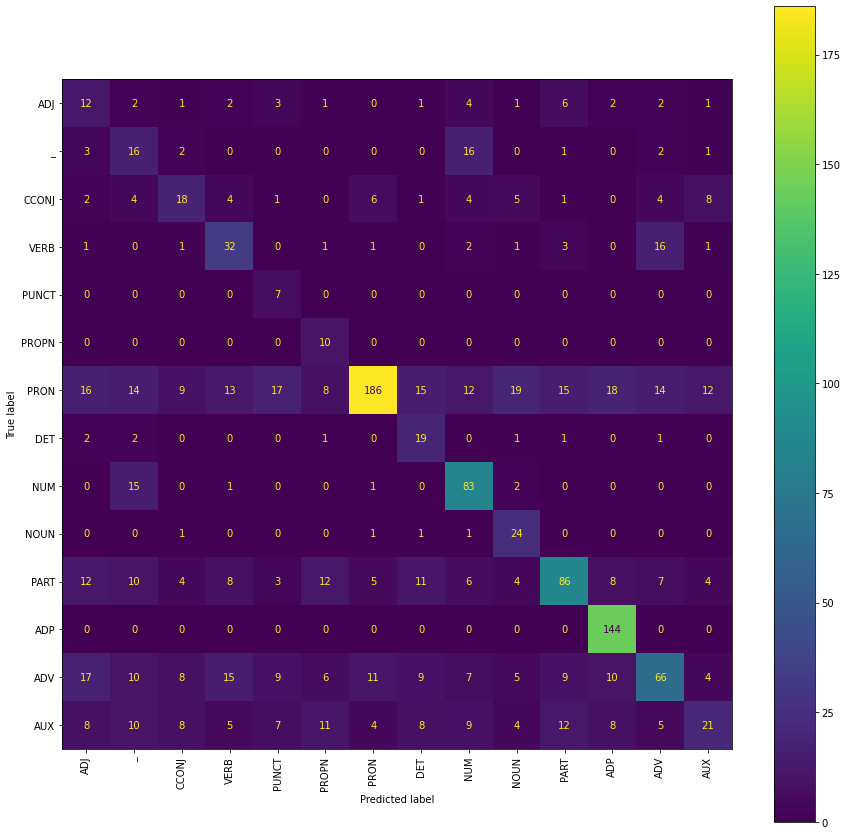

In [14]:
cm = confusion_matrix(flatten_gold_truth, flatten_predictions)

cmd = ConfusionMatrixDisplay(cm, display_labels=combined_label_list)

fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)

cmd.plot(xticks_rotation='vertical', ax =ax)

In [15]:
    
# For tasks requiring phrase-level annotation
# from seqeval.metrics import accuracy_score
# from seqeval.metrics import classification_report
# from seqeval.metrics import f1_score
# from seqeval.scheme import IOB1
# print('F1 Score is')
# print( f1_score(ground_truth, prediction) )

# print('Classification report')
# print( classification_report(ground_truth, prediction, scheme=IOB1) )

## Implement Rule-based System here

Let us write a simple rule to tag adverbs

In [16]:
affix_pos_frequency = {}

for every_word in word_pos_frequency:
    if len(every_word) > 5:
        bi_gram_character = every_word[ -2: ]
        tri_gram_character = every_word[ -3: ]
        
        if bi_gram_character in affix_pos_frequency:
            for key in word_pos_frequency[ every_word ]:
                if key in affix_pos_frequency[bi_gram_character]:
                    affix_pos_frequency[bi_gram_character][key] += word_pos_frequency[ every_word ][key]
                else:
                    affix_pos_frequency[bi_gram_character][key] = word_pos_frequency[ every_word ][key]
        else:
            affix_pos_frequency[bi_gram_character] = word_pos_frequency[every_word]
            
        if tri_gram_character in affix_pos_frequency:
            for key in word_pos_frequency[ every_word ]:
                if key in affix_pos_frequency[tri_gram_character]:
                    affix_pos_frequency[tri_gram_character][key] += word_pos_frequency[ every_word ][key]
                else:
                    affix_pos_frequency[tri_gram_character][key] = word_pos_frequency[ every_word ][key]
        else:
            affix_pos_frequency[tri_gram_character] = word_pos_frequency[every_word]


In [17]:
ground_truth = []
prediction = []

for every_sentence in test_split:
    ground_truth_sentence = []
    prediction_sentence = []

    word_index = 0
    for every_token in every_sentence:
        word_index = word_index + 1
        word, label = every_token
        ground_truth_sentence.append( label )
        
        word_bi_gram = every_token[0][-2:]
        word_tri_gram = every_token[0][-3:]
        
        if word in word_pos_frequency:
            prediction_sentence.append( getMax( word_pos_frequency[word] ) )
        elif word_tri_gram in affix_pos_frequency:
            prediction_sentence.append( getMax( affix_pos_frequency[word_tri_gram] ) )
        elif word_bi_gram in affix_pos_frequency:
            prediction_sentence.append( getMax( affix_pos_frequency[word_bi_gram] ) )
        else:
            prediction_sentence.append( random.choice( combined_label_list ) )

    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )

In [18]:
flatten_gold_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]

print(classification_report(flatten_gold_truth, flatten_predictions, target_names=combined_label_list, digits=4))

              precision    recall  f1-score   support

         ADJ     0.2424    0.4211    0.3077        38
           _     0.1190    0.3659    0.1796        41
       CCONJ     0.2188    0.3621    0.2727        58
        VERB     0.3168    0.5424    0.4000        59
       PUNCT     0.8750    1.0000    0.9333         7
       PROPN     0.4286    0.9000    0.5806        10
        PRON     0.8843    0.5190    0.6541       368
         DET     0.3256    0.5185    0.4000        27
         NUM     0.6279    0.7941    0.7013       102
        NOUN     0.6389    0.8214    0.7187        28
        PART     0.5879    0.6500    0.6174       180
         ADP     0.9796    1.0000    0.9897       144
         ADV     0.5952    0.4032    0.4808       186
         AUX     0.5926    0.2667    0.3678       120

    accuracy                         0.5680      1368
   macro avg     0.5309    0.6117    0.5431      1368
weighted avg     0.6584    0.5680    0.5857      1368

